In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


En primer lugar, comenzamos leyendo el archivo.


In [2]:
filename = "/content/BTC-USD.csv"
df = pd.read_csv(filename) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Para revisar hasta que fecha tenemos la información, revisamos también los ultimos valores del dataset y vemos que la información con la cual haremos el proyecto llega hasta el 5 de Mayo de 2022.


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2783,2022-05-01,37713.265625,38627.859375,37585.789063,38469.093750,38469.093750,27002760110
2784,2022-05-02,38472.187500,39074.972656,38156.562500,38529.328125,38529.328125,32922642426
2785,2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,37750.453125,27326943244
2786,2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490
2787,2022-05-05,39727.386719,39788.441406,39444.644531,39568.812500,39568.812500,34693083136


Luego, analizaremos las características descriptivas para conocer más de la base con la cual trabajaremos.

In [4]:
df.shape

(2788, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2788 entries, 0 to 2787
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2788 non-null   object 
 1   Open       2788 non-null   float64
 2   High       2788 non-null   float64
 3   Low        2788 non-null   float64
 4   Close      2788 non-null   float64
 5   Adj Close  2788 non-null   float64
 6   Volume     2788 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 152.6+ KB


De lo anterior notamos que no contamos con datos nulos, por lo que no es necesario trabajar en la limpieza de éstos.

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2.788000e+03
mean,12114.051628,12432.075536,11764.920824,12126.416572,12126.416572,1.504640e+10
std,16612.538889,17044.777808,16119.346993,16615.381435,16615.381435,1.988339e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,612.573471,618.876495,609.665756,613.742477,613.742477,8.317548e+07
50%,6457.810059,6549.650147,6353.985107,6466.239990,6466.239990,5.401853e+09
75%,11024.040039,11388.611572,10722.320557,11056.325195,11056.325195,2.558002e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
df.duplicated().sum()

0

Además, tampoco existen datos duplicados.

A continuación se realizaran algunas visualizaciones de la data original, para comprender como se relacionan las variables.

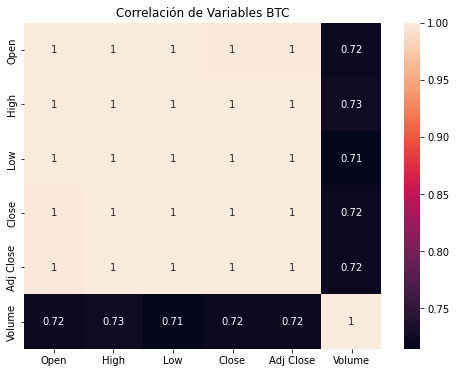

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
corr=df.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title('Correlación de Variables BTC')
plt.show()

Visualización del precio historico del Bitcoin a la fecha (5/5/2022).

Text(0.5, 1.0, 'Precio de Cierre vs Fecha')

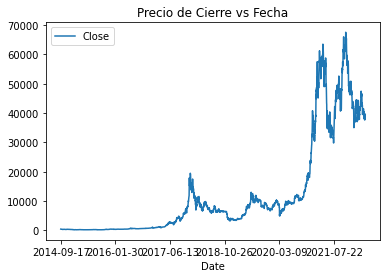

In [9]:
df.plot.line(y="Close", x="Date")
plt.title('Precio de Cierre vs Fecha')

Text(0.5, 1.0, 'Volumen vs Fecha')

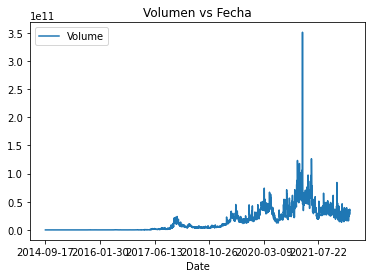

In [12]:
df.plot.line(y="Volume", x="Date")
plt.title('Volumen vs Fecha')

Lo que se hará a continuación, será agregar una columna nueva llamada "Tomorrow", que tomará el valor de "Close" del día posterior y se lo colocará en la fila de la fecha actual como nueva columna. Esto nos ayudará a crear nuestra variable "Target" para evaluar si el precio sube o baja entre los días.

In [15]:
df["Tomorrow"] = df["Close"].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Tomorrow
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,424.440002
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,394.795990
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,408.903992
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,398.821014
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,402.152008


Ahora se podrá establecer la variable "Target", que indicará con un "1" si el precio subió y con "0" si bajó.

In [17]:
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,424.440002,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,394.795990,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,408.903992,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,398.821014,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,402.152008,1


Antes de comenzar el modelamiento, revisaremos la cantidad de dias que el precio subió vs la cantidad de dias que el precio bajó.

In [26]:
df["Target"].value_counts()

1    1506
0    1282
Name: Target, dtype: int64

Text(0.5, 1.0, 'Histogram Target Count')

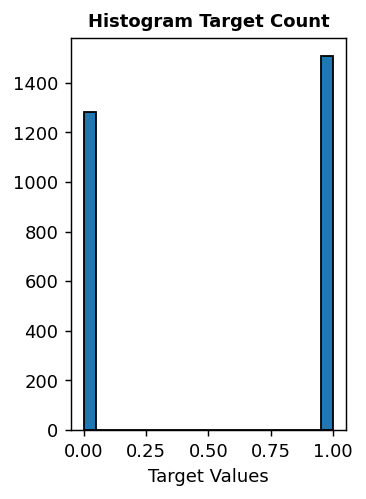

In [30]:
fig5=plt.figure(dpi=130) 


x1 = df["Target"]
ax1 = fig5.add_subplot(1,2,1)
ax1.hist(x1, bins = 20, edgecolor='black')
ax1.set_xlabel("Target Values")
ax1.set_title('Histogram Target Count',fontsize=10, fontweight="bold")


Ahora, comenzaremos el modelamiento con un desarrollo inicial de Random Forest para evaluar en primera instancia la predicción de nuestro modelo.

In [287]:
predictors1 = df[["Close", "Volume", "Open", "High", "Low"]]
predictors1.head()

,Close,Volume,Open,High,Low
0,457.334015,21056800,465.864014,468.174011,452.421997
1,424.440002,34483200,456.859985,456.859985,413.104004
2,394.795990,37919700,424.102997,427.834991,384.532013
3,408.903992,36863600,394.673004,423.295990,389.882996
4,398.821014,26580100,408.084991,412.425995,393.181000


In [288]:
pred1= df[["Target"]]

In [306]:
# Total dataset length
dataset_length = df.shape[0]

# Training dataset length
split = int(dataset_length * 0.85)
split

2369

In [307]:
# Splitiing the X and y into train and test datasets
X_train, X_test = predictors1[:split], predictors1[split:]
y_train, y_test = pred1[:split], pred1[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2369, 5) (419, 5)
(2369, 1) (419, 1)


In [373]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [374]:
model = clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [375]:
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  51.07398568019092


In [324]:
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       210
           1       0.51      0.51      0.51       209

    accuracy                           0.51       419
   macro avg       0.51      0.51      0.51       419
weighted avg       0.51      0.51      0.51       419



Ahora evaluaremos el modelo KNN

In [325]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [326]:
predictors2 = df[["Close", "Volume", "Open", "High", "Low"]]
predictors2.head()

,Close,Volume,Open,High,Low
0,457.334015,21056800,465.864014,468.174011,452.421997
1,424.440002,34483200,456.859985,456.859985,413.104004
2,394.795990,37919700,424.102997,427.834991,384.532013
3,408.903992,36863600,394.673004,423.295990,389.882996
4,398.821014,26580100,408.084991,412.425995,393.181000


In [327]:
pred2= df[["Target"]]

In [328]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [329]:
# Total dataset length
dataset_length = df.shape[0]

# Training dataset length
split2 = int(dataset_length * 0.85)
split2

2369

In [330]:
#split_percentage = 0.85
#split = int(split_percentage*len(df))

X_train2 = predictors2[:split2]
Y_train2 = pred2[:split2]

X_test2 = predictors2[split2:]
Y_test2 = pred2[split2:]

In [331]:
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model
knn.fit(X_train2, Y_train2)

# Accuracy Score
accuracy_train = accuracy_score(Y_train2, knn.predict(X_train2))
accuracy_test = accuracy_score(Y_test2, knn.predict(X_test2))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.64
Test_data Accuracy: 0.48


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Al evaluar ambos modelos, vemos que Random Forest es levemente superior (0.51), además de ser menos propenso al "Over Fit". Por esto, se buscará mejorar el modelo de Random Forest para seguir con el proyecto.

In [332]:
predictors3 = df[["Close", "Volume", "Open", "High", "Low"]]
predictors3.head()

,Close,Volume,Open,High,Low
0,457.334015,21056800,465.864014,468.174011,452.421997
1,424.440002,34483200,456.859985,456.859985,413.104004
2,394.795990,37919700,424.102997,427.834991,384.532013
3,408.903992,36863600,394.673004,423.295990,389.882996
4,398.821014,26580100,408.084991,412.425995,393.181000


In [333]:
pred3= df[["Target"]]

In [335]:
# Total dataset length
dataset_length = df.shape[0]

# Training dataset length
split3 = int(dataset_length * 0.85)
split3

2369

In [336]:
# Splitiing the X and y into train and test datasets
X_train3, X_test3, X_val = predictors3[:split3], predictors1[split3:], predictors3[split3:]
y_train3, y_test3, y_val = pred3[:split3], pred3[split3:], pred3[split3:]

# Print the size of the train and test dataset
print(X_train3.shape, X_test3.shape)
print(y_train3.shape, y_test3.shape)

(2369, 5) (419, 5)
(2369, 1) (419, 1)


In [337]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train3)
X_train3 = scaler.transform(X_train3)
X_test3 = scaler.transform(X_test3)
X_val=scaler.transform(X_val)

In [340]:
param_grid = [
    {'n_estimators':[100,150,200,250,300,350,400,450]}
]

forest_clf = RandomForestClassifier()

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                          return_train_score=True)

grid_search.fit(X_train3, y_train3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                           450]}],
             return_train_score=True)

In [341]:
cvres = grid_search.cv_results_
print(cvres['mean_test_score'], cvres['params'])

[0.48627488 0.4883828  0.49471905 0.49682697 0.49176635 0.49893935
 0.49134441 0.49429622] [{'n_estimators': 100}, {'n_estimators': 150}, {'n_estimators': 200}, {'n_estimators': 250}, {'n_estimators': 300}, {'n_estimators': 350}, {'n_estimators': 400}, {'n_estimators': 450}]


In [377]:
rndf_clf = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
rndf_clf.fit(X_train3, y_train3)
y_pred3 = rndf_clf.predict(X_val)

#print(y_pred)
#print(y_val.tolist())
rndf_clf.score(X_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.5322195704057279

Si tomamos 100 estimadores, el modelo mejora llegano a 0.53. Es una leve mejora, que no demuestra un gran valor de accuracy, pero es normal cuando nos referimos a la predicción de precios de BTC, un activo sumamente volátil.